Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    
# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import base64
from IPython.display import HTML


warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_rows = 1000

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle InClass competition website (the URL is in Slack). Go to the **Rules** page. Accept the rules of the competition. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [4]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [5]:
df = wrangle("train_features.csv","train_labels.csv")

X_test = wrangle('test_features.csv')
X_test.drop(columns=['waterpoint_type_group'], inplace=True)

In [6]:
X_test

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,,
37098,NaN,NaN,31.985658,-3.596360,NaN,Lake Tanganyika,Shinyanga,17,5.0,NaN,...,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other
14530,NaN,NaN,32.832815,-4.944937,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,...,user-group,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump
62607,10.0,1675.0,35.488289,-4.242048,NaN,Internal,Manyara,21,1.0,148.0,...,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe
46053,NaN,NaN,33.140828,-9.059386,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,user-group,never pay,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump
47083,50.0,1109.0,34.217077,-4.430529,NaN,Internal,Singida,13,1.0,235.0,...,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26092,200.0,1775.0,34.588725,-9.789187,NaN,Lake Nyasa,Iringa,11,5.0,530.0,...,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe
919,500.0,1850.0,36.645251,-3.252351,NaN,Pangani,Arusha,2,2.0,150.0,...,user-group,pay when scheme fails,on failure,soft,good,enough,spring,spring,groundwater,other
47444,NaN,NaN,30.543984,-2.488919,NaN,Lake Victoria,Kagera,18,30.0,NaN,...,user-group,never pay,never pay,soft,good,dry,spring,spring,groundwater,communal standpipe


# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [7]:
target = 'status_group'

X = df.drop(columns=target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=.2,random_state=42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [9]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [60]:
model_dt = make_pipeline(
OrdinalEncoder(),
SimpleImputer(strategy='median'),
DecisionTreeClassifier(splitter='best',max_depth=16.4,random_state=42,min_samples_split=4,min_samples_leaf=15,min_impurity_decrease=.000005))

model_dt.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_typ...
                                         {'col': 'waterpoint_type',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump                      1
communal 

In [61]:
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8045771406023938
Validation Accuracy Score: 0.7627314814814815


# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [48]:
depths=range(5,35,1)
train_acc = []
validation_acc = []

for depth in depths:
    model_pt = make_pipeline(OrdinalEncoder(),
                             SimpleImputer(strategy='mean'),
                             DecisionTreeClassifier(splitter='best',max_depth=16.4,random_state=42,min_samples_split=4,min_samples_leaf=depth,min_impurity_decrease=.000005))
    
    model_pt.fit(X_train,y_train)
    train_acc.append(model_pt.score(X_train,y_train))
    validation_acc.append(model_pt.score(X_val,y_val))

In [23]:
validation_acc

[0.7658880471380471,
 0.764520202020202,
 0.7644149831649831,
 0.7639941077441077,
 0.7664141414141414,
 0.7671506734006734,
 0.7664141414141414,
 0.765256734006734,
 0.7655723905723906,
 0.765993265993266,
 0.7660984848484849,
 0.7656776094276094,
 0.7655723905723906,
 0.7663089225589226,
 0.76378367003367,
 0.7642045454545454,
 0.7643097643097643,
 0.7640993265993266,
 0.7642045454545454,
 0.7627314814814815,
 0.7614688552188552,
 0.7616792929292929,
 0.7618897306397306,
 0.7612584175084175,
 0.7617845117845118,
 0.7621001683501684,
 0.7619949494949495,
 0.7616792929292929,
 0.7621001683501684,
 0.7614688552188552]

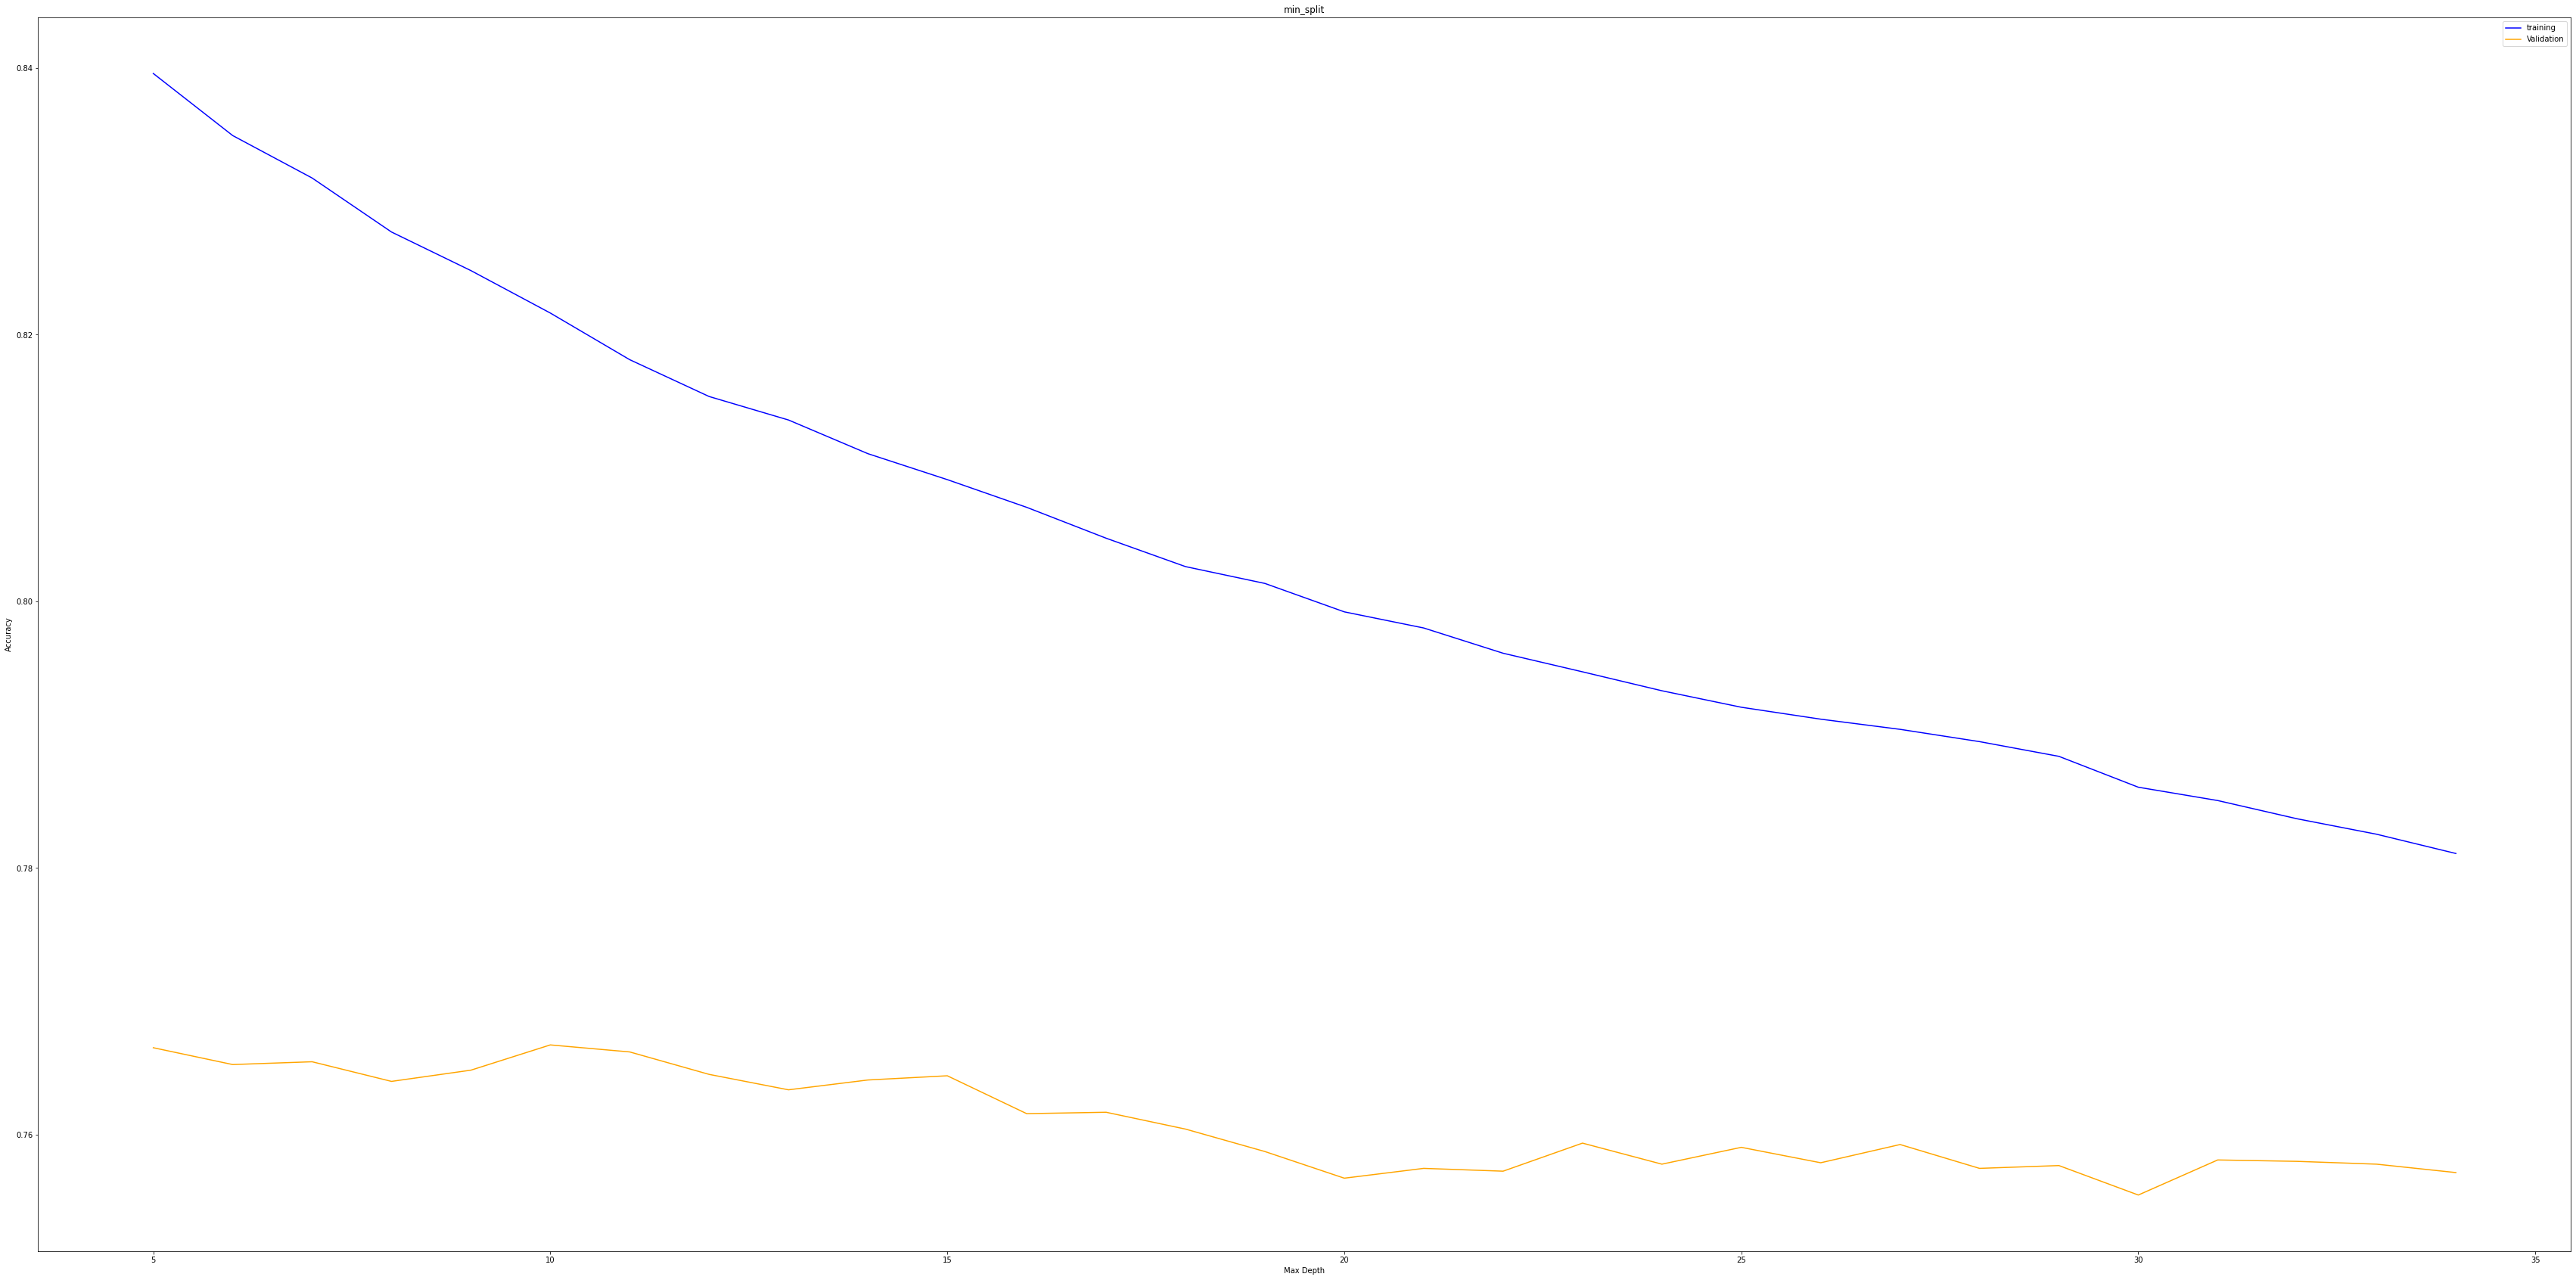

In [49]:
plt.figure(figsize=(60,30))
plt.plot(depths,train_acc,color='blue',label='training')
plt.plot(depths,validation_acc,color='orange',label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('min_split')
plt.legend()
plt.show();

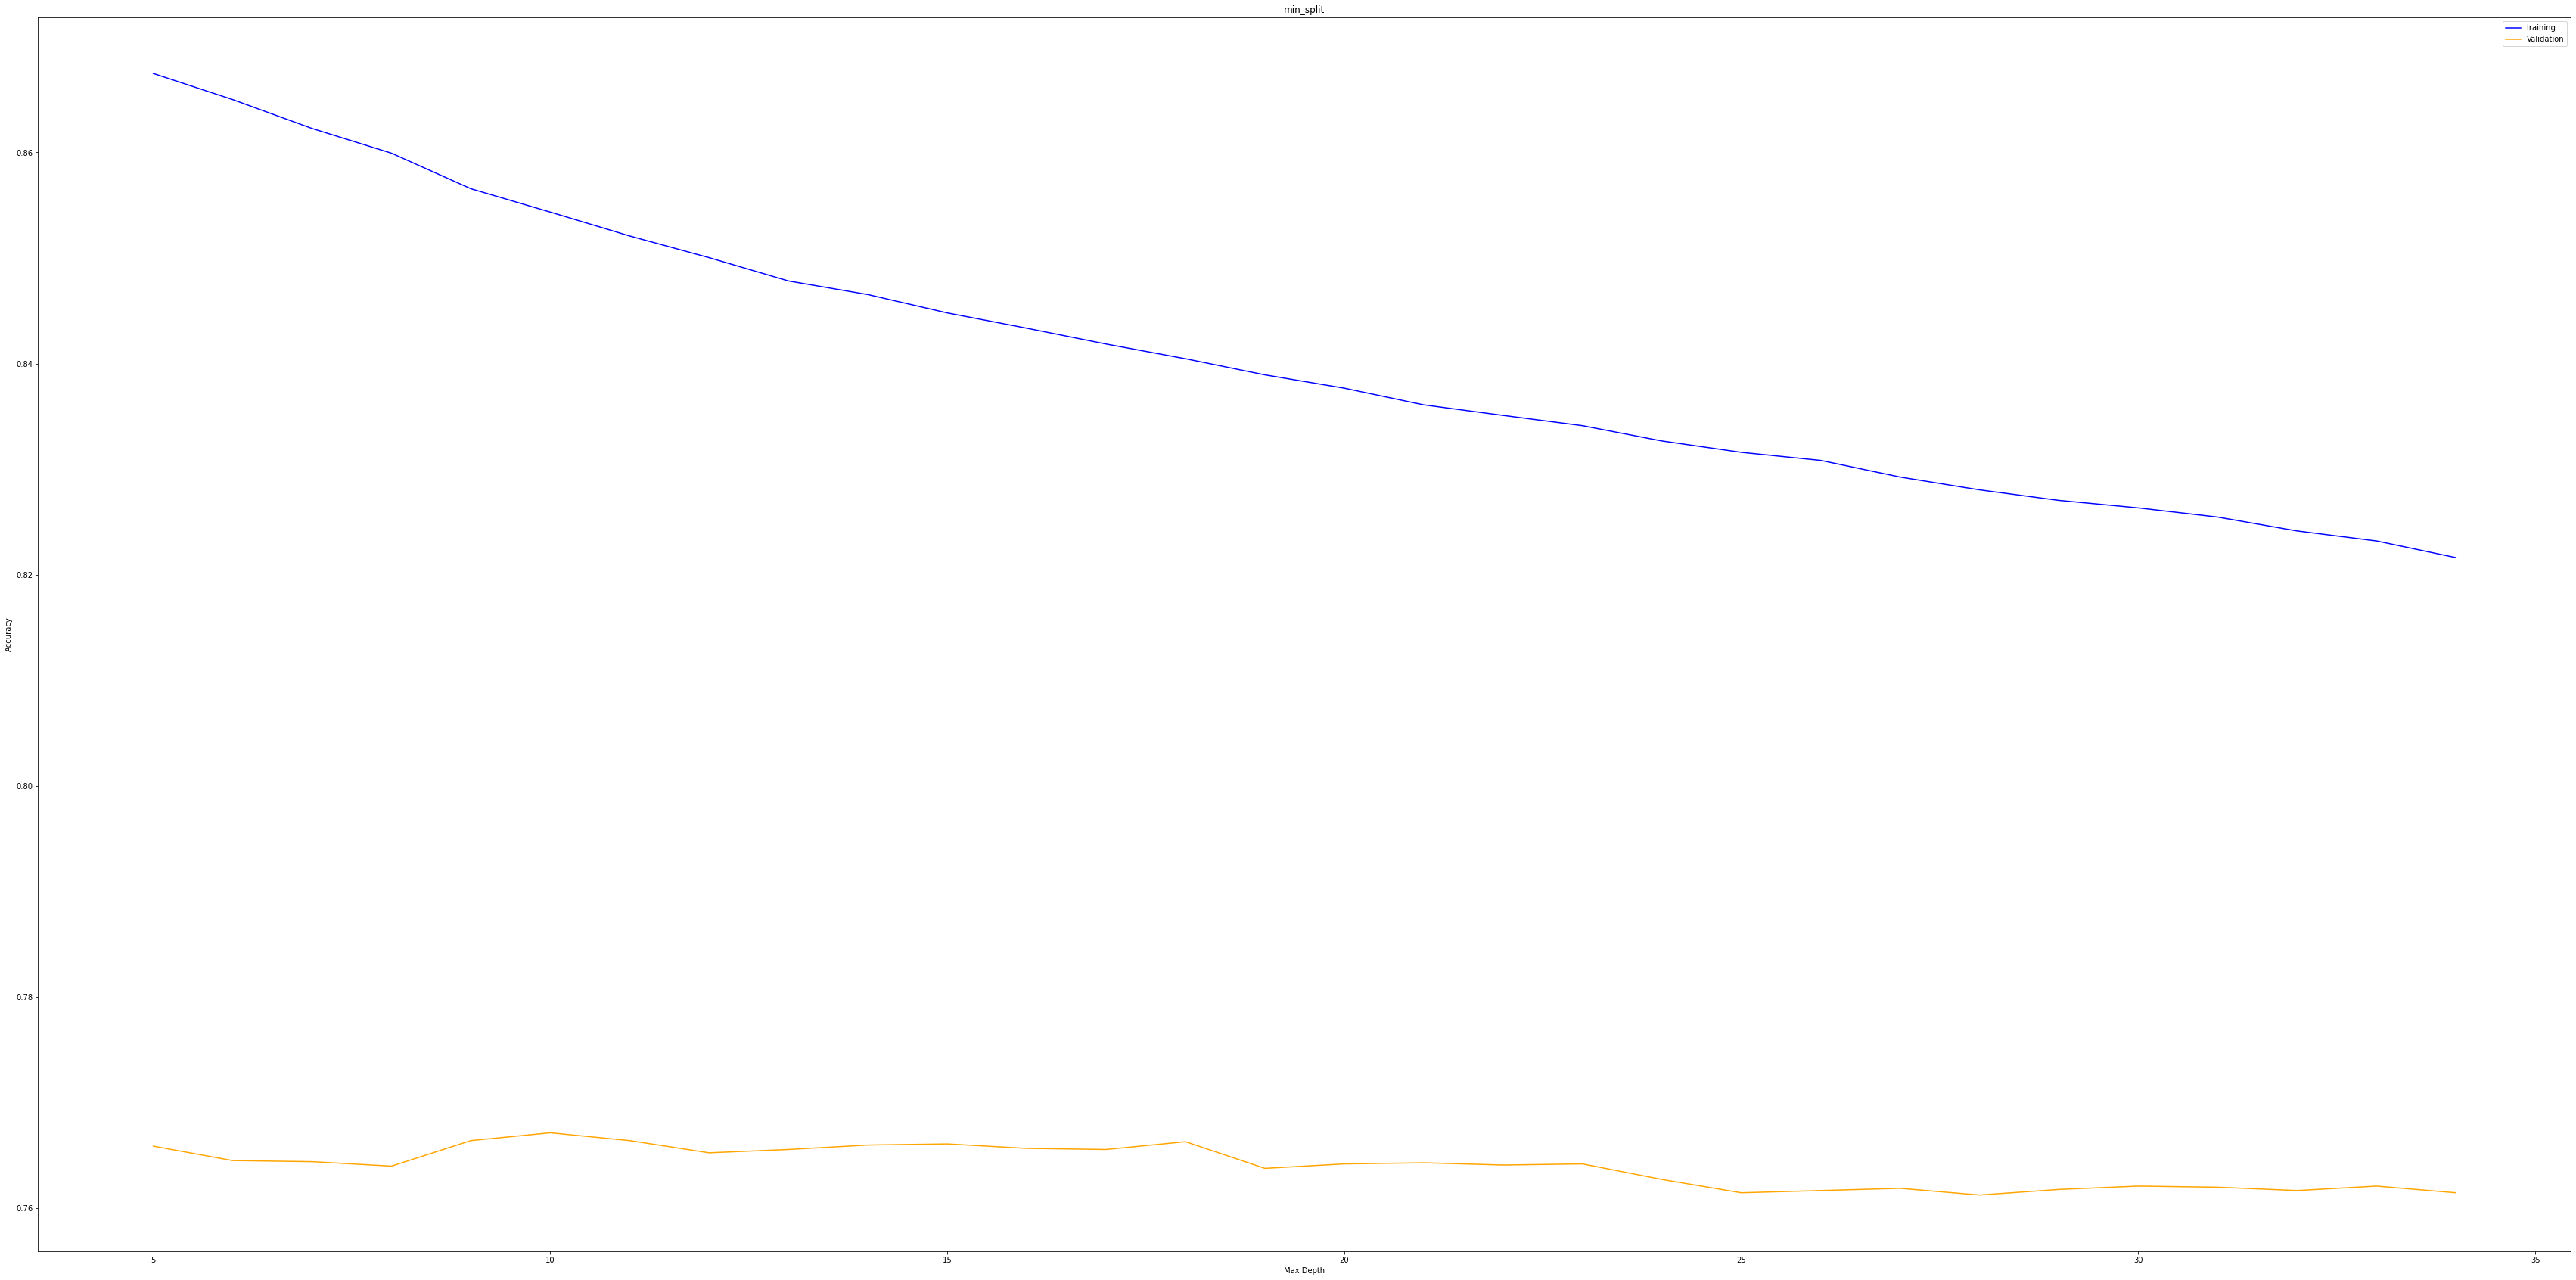

In [21]:
plt.figure(figsize=(60,30))
plt.plot(depths,train_acc,color='blue',label='training')
plt.plot(depths,validation_acc,color='orange',label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('min_split')
plt.legend()
plt.show();

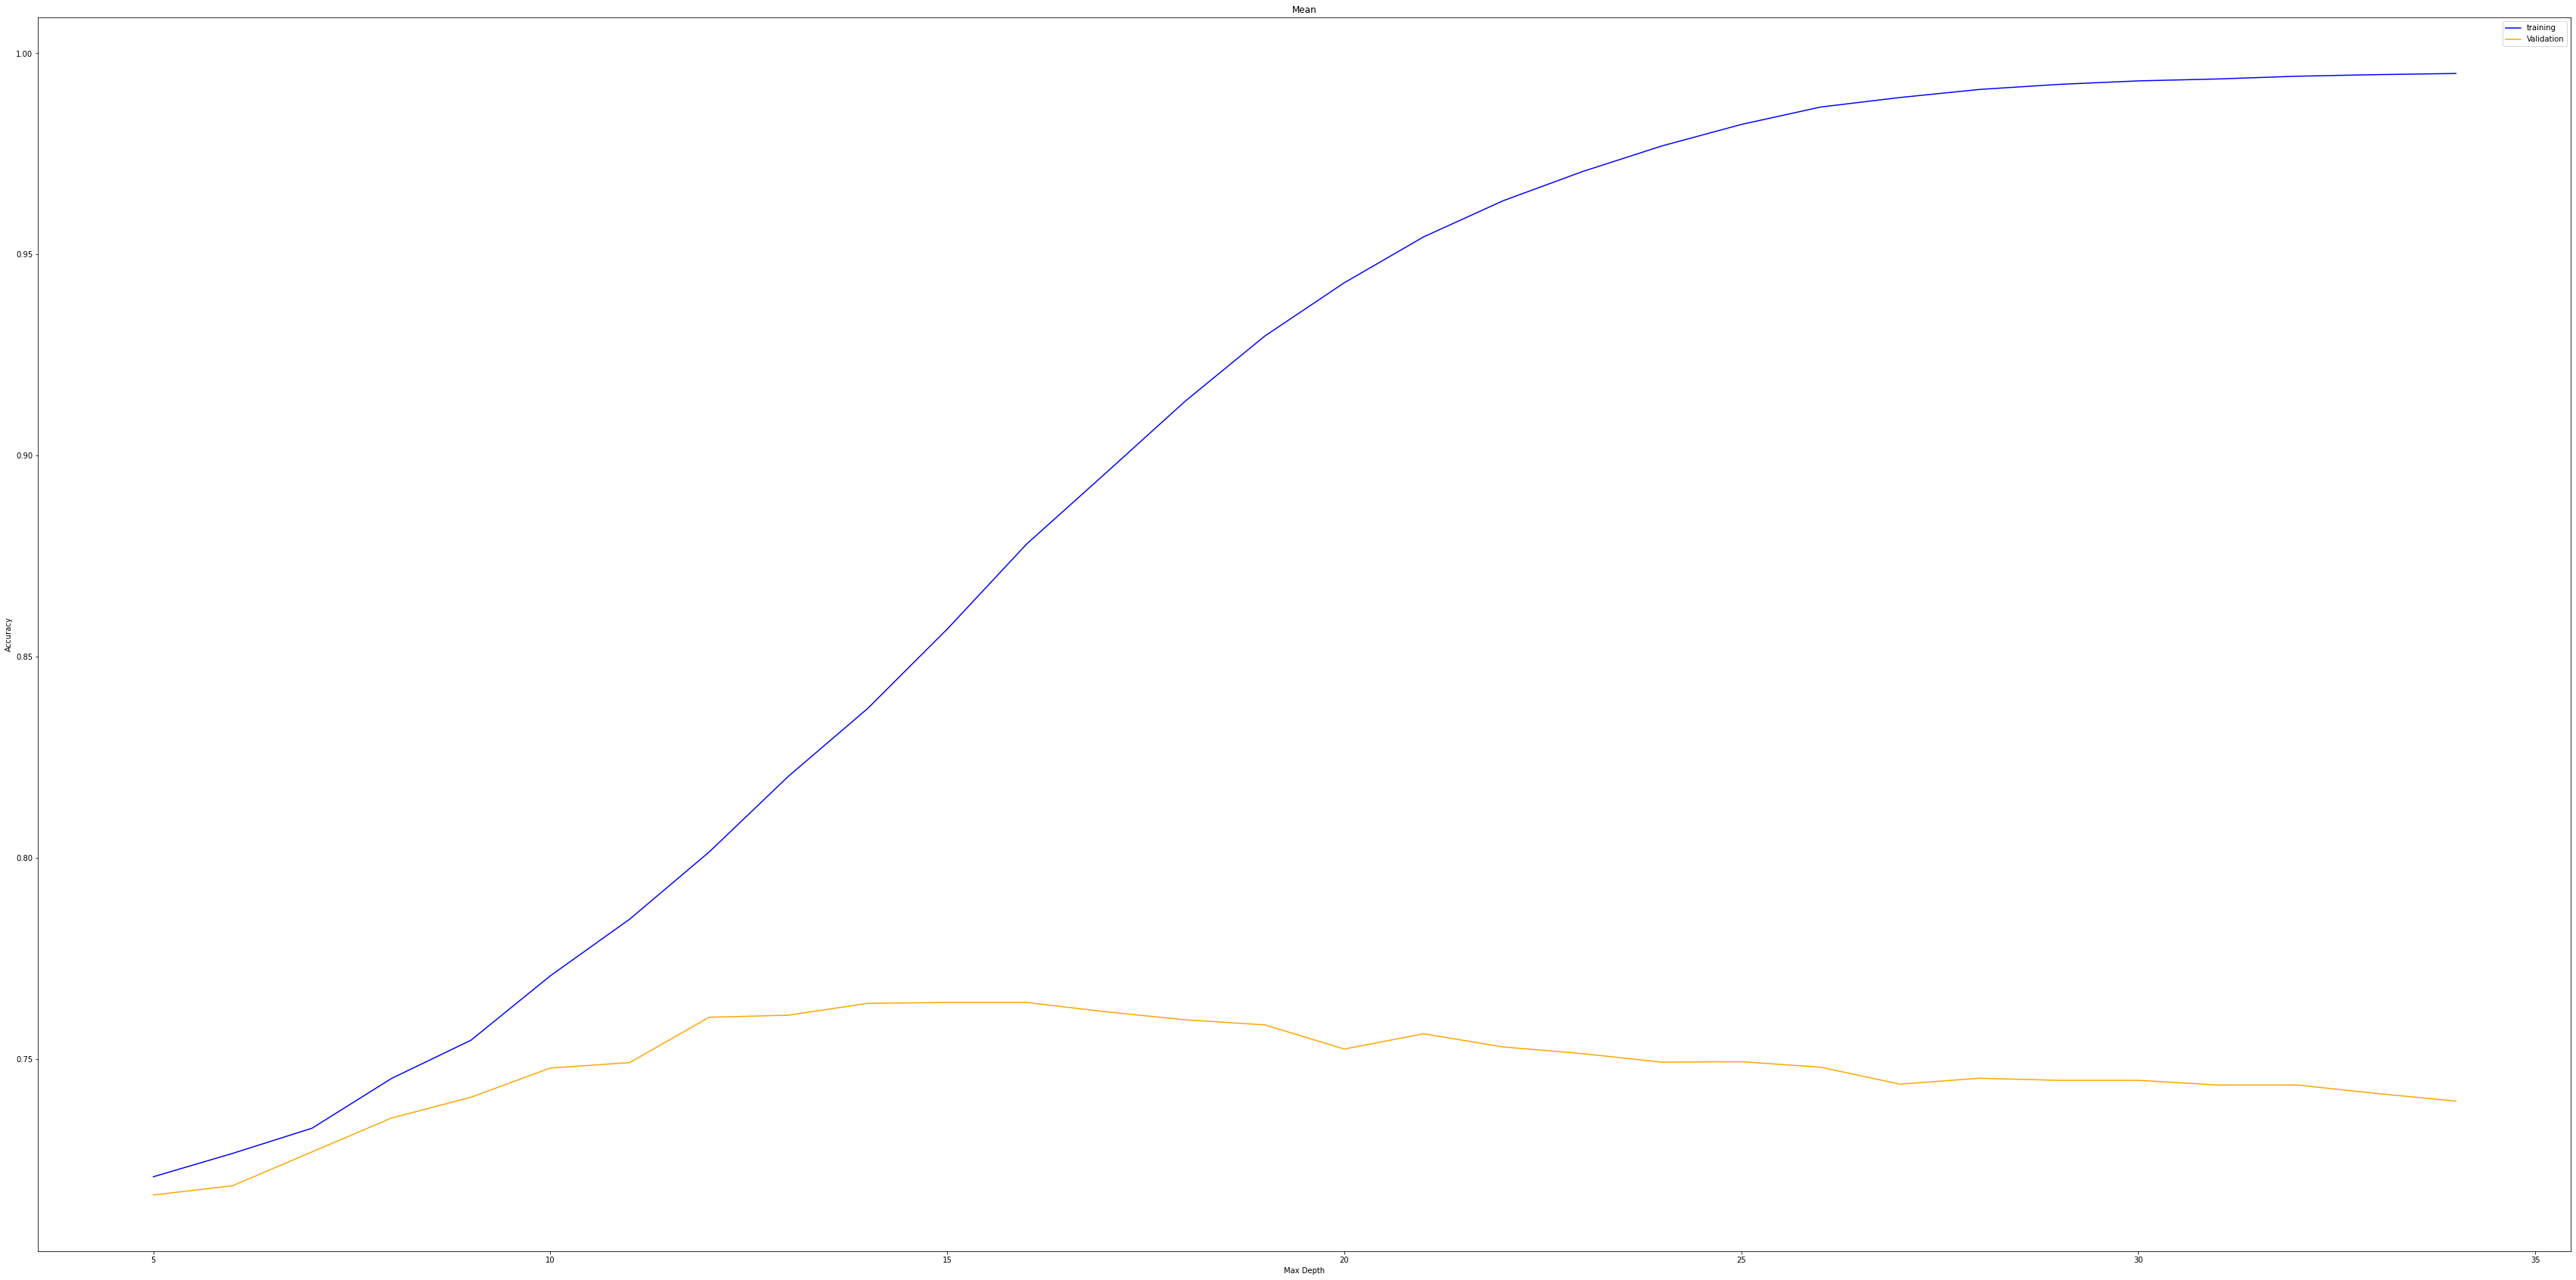

In [18]:
plt.figure(figsize=(60,30))
plt.plot(depths,train_acc,color='blue',label='training')
plt.plot(depths,validation_acc,color='orange',label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Mean')
plt.legend()
plt.show();

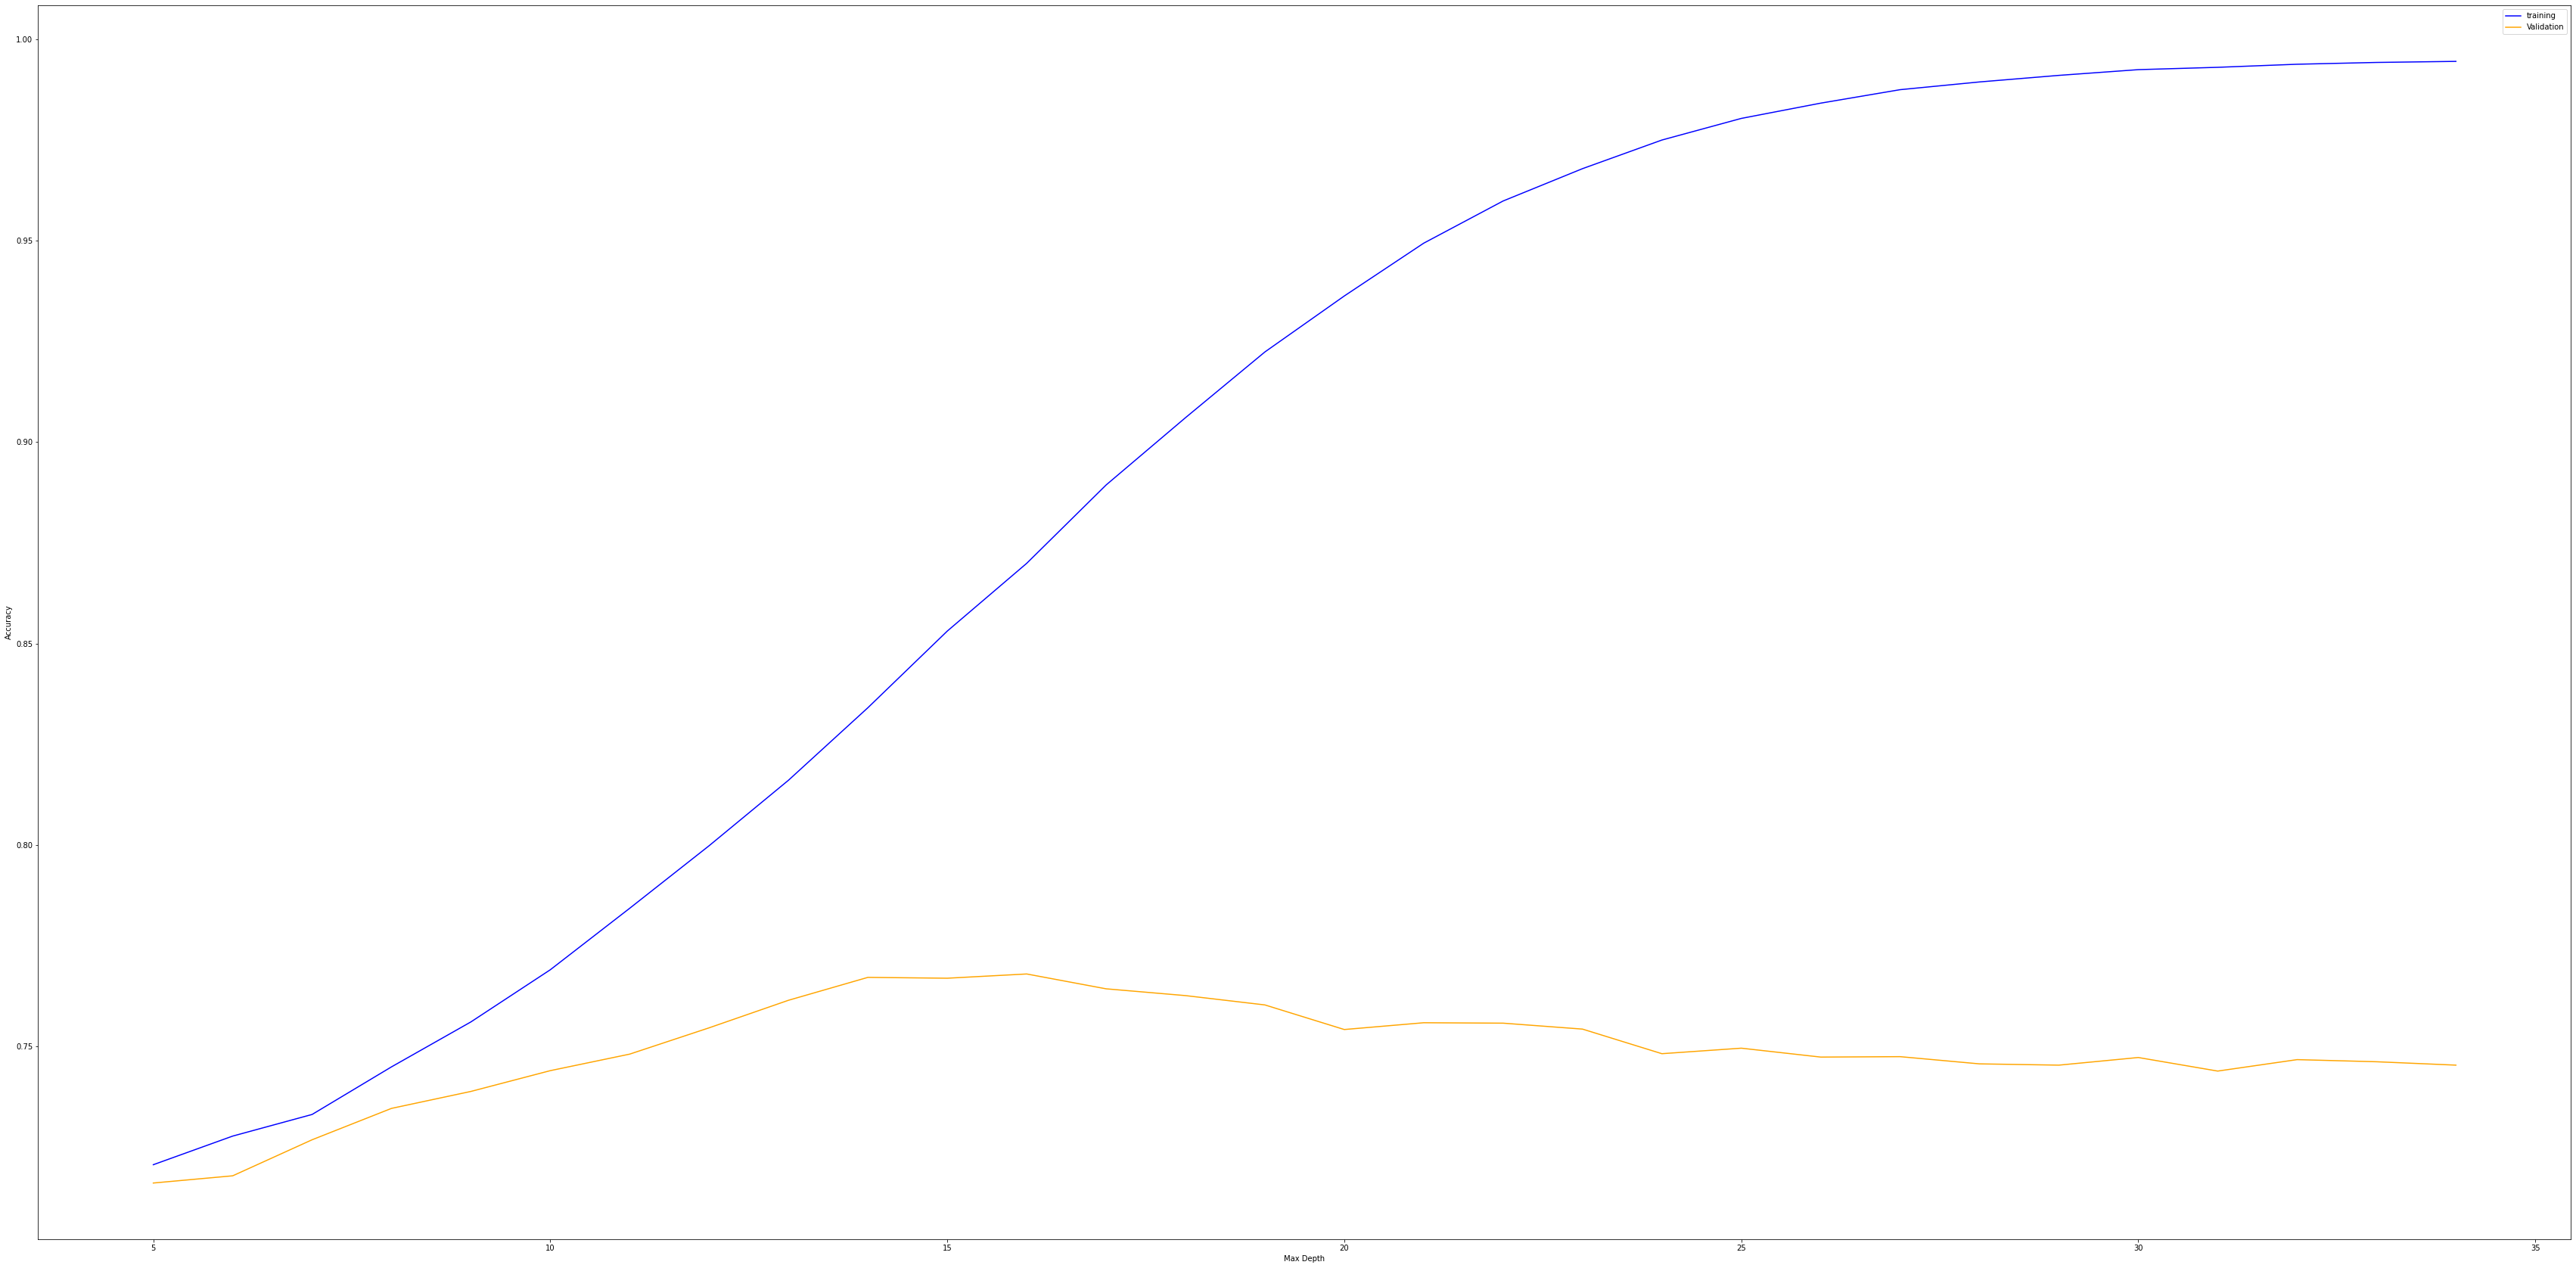

In [129]:
plt.figure(figsize=(60,30))
plt.plot(depths,train_acc,color='blue',label='training')
plt.plot(depths,validation_acc,color='orange',label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Median')
plt.legend()
plt.show();

# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

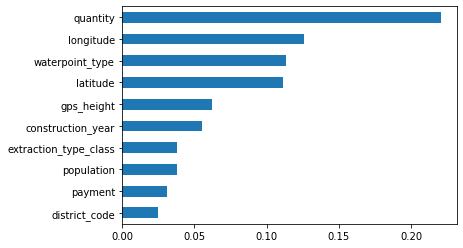

In [122]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini =  model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini,index=features).sort_values(key=abs).tail(10).plot(kind='barh');

In [180]:
# Predict X_test and use the ids from the test data
predictions = pd.DataFrame(data=model_dt.predict(X_test), index=X_test.index)
# Rename column to be status_group because that is the submission format
predictions.columns = ['status_group']
predictions.head()

,status_group
id,
37098,non functional
14530,functional
62607,functional
46053,functional
47083,functional


In [182]:
# generate CSV
predictions = predictions.to_csv('new_submission.csv')

In [188]:
# download
from google.colab import files
files.download("new_submission.csv")

ModuleNotFoundError: No module named 'google'